# Install Dependencies

In [1]:
!pip install tensorflow

In [2]:
!pip install opencv-python

# Import Dependencies

In [3]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create Folder Structures

In [6]:
# Identifying current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: C:\Users\pragy


In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [75]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

 # Collect Positives and Anchors

Labeled Faces in the Wild is a public benchmark for face verification. 

In [8]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Collect Positives and Anchors

In [10]:
# Import uuid library to generate unique image names
# uuid --> universally unique identifier
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\9830ce16-9018-11ee-98cc-3c58c21872c4.jpg'

In [13]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[150:150+250,200:200+250,:]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

# Load and Preprocess Images

In [24]:
# Get Image Directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [25]:
dir_test = anchor.as_numpy_iterator()

In [26]:
print(dir_test.next())

b'data\\anchor\\b8c8f48b-82b4-11ee-9225-3c58c21872c4.jpg'


# Preprocessing - Scale and Resize

In [27]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [28]:
img  = preprocess(b'data\\anchor\\8b2c966c-82b4-11ee-9e23-3c58c21872c4.jpg')

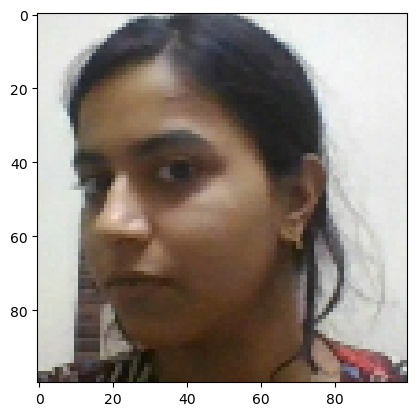

In [29]:
plt.imshow(img)

In [30]:
print(img.numpy().min())
print(img.numpy().max())

0.007352941
0.9747549


# Create labelled dataset

In [31]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [32]:
print(data.take(1))
print(tf.data.experimental.cardinality(data).numpy())

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
600


In [33]:
samples = data.as_numpy_iterator()
example = samples.next()
print(example)

(b'data\\anchor\\8e02e9c6-82b4-11ee-8f93-3c58c21872c4.jpg', b'data\\positive\\8f4764f6-82b6-11ee-aa5b-3c58c21872c4.jpg', 1.0)


# Build Train and Test Partition

In [34]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*example)
print(res)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.92941177, 0.92941177, 0.92941177],
        [0.93210787, 0.93210787, 0.93210787],
        [0.93602943, 0.93602943, 0.93602943],
        ...,
        [0.3718137 , 0.36789215, 0.4247549 ],
        [0.34558824, 0.34166667, 0.40441176],
        [0.33431372, 0.3382353 , 0.40882352]],

       [[0.9362745 , 0.9264706 , 0.93039215],
        [0.93235296, 0.9245098 , 0.9284314 ],
        [0.9352941 , 0.92745095, 0.9313725 ],
        ...,
        [0.3382353 , 0.34607843, 0.39607844],
        [0.34264705, 0.35049018, 0.4004902 ],
        [0.34901962, 0.35392156, 0.4117647 ]],

       [[0.9343137 , 0.91862744, 0.922549  ],
        [0.94436276, 0.93063724, 0.9345588 ],
        [0.9338235 , 0.9245098 , 0.9284314 ],
        ...,
        [0.3367647 , 0.34460783, 0.39460784],
        [0.3514706 , 0.35931373, 0.40931374],
        [0.36078432, 0.35686275, 0.4117647 ]],

       ...,

       [[0.970098  , 0.9504902 , 0.9262255 ],
        [0.9

Text(0.5, 1.0, 'Validation Imaneg')

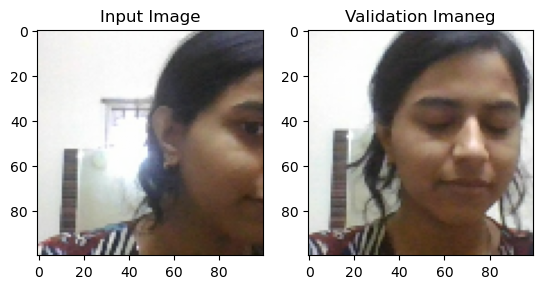

In [35]:
plt.subplot(1,2,1)
plt.imshow(res[0])
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(res[1])
plt.title('Validation Imaneg')

In [36]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

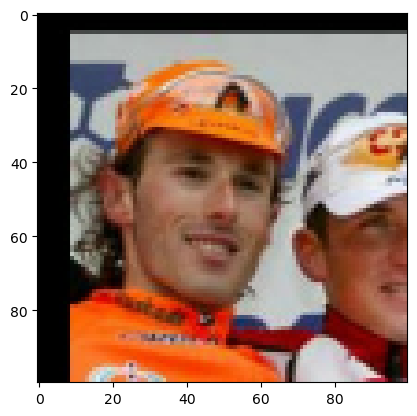

In [37]:
sample = data.as_numpy_iterator()
samp = sample.next()
plt.imshow(samp[1])

In [38]:
samp[2]

0.0

In [39]:
round(len(data)*.7)

420

In [40]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [41]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [42]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0])

16

In [43]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

In [44]:
# Build Embedding Layer
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [45]:
embedding = make_embedding()
embedding.summary()



Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       

# Build Distance Layer

In [46]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [47]:
l1 = L1Dist()

# Make Siamese Model

In [48]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Training

In [50]:
# Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [51]:
# Setup of Adaptive Moment Estimation optimizer
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [52]:
# Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [53]:
# Build Train Step Function
test_batch = train_data.as_numpy_iterator()

In [54]:
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

In [55]:
y

array([1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [56]:
@tf.function
def train_step(batch): 
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

# Build Training Loop

In [57]:
from tensorflow.keras.metrics import Precision, Recall

In [58]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) 
        r = Recall()
        p = Precision()
        
    
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train the model

In [59]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 57s 2s/step
0.523285 0.27962086 0.98333335

 Epoch 2/50
27/27 [==============================] - 55s 2s/step
0.07550274 0.89908254 0.98

 Epoch 3/50
27/27 [==============================] - 59s 2s/step
0.1784924 0.9859813 0.995283

 Epoch 4/50
27/27 [==============================] - 61s 2s/step
0.08452442 1.0 1.0

 Epoch 5/50
27/27 [==============================] - 60s 2s/step
0.020282421 0.98029554 0.995

 Epoch 6/50
27/27 [==============================] - 62s 2s/step
0.0037171515 1.0 0.9951923

 Epoch 7/50
27/27 [==============================] - 63s 2s/step
0.0017906296 0.9906977 1.0

 Epoch 8/50
27/27 [==============================] - 58s 2s/step
0.13018203 0.9953704 1.0

 Epoch 9/50
27/27 [==============================] - 58s 2s/step
0.010191541 1.0 1.0

 Epoch 10/50
27/2

# Evaluate Model

In [60]:
from tensorflow.keras.metrics import Precision, Recall

In [61]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [62]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 893ms/step


In [63]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]

In [64]:
y_true

array([1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

# Calculate Metrics

In [65]:
m = Recall() 
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [66]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [67]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 312ms/step
1.0 1.0


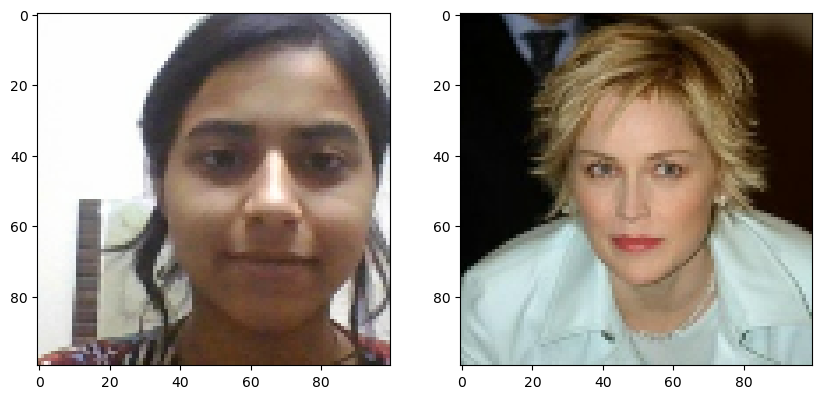

In [68]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

# Save Model

In [69]:
siamese_model.save('siamesemodelv2.h5')

C:\Users\pragy\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
L1Dist

__main__.L1Dist

In [71]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [72]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 616ms/step


array([[7.4307747e-12],
       [1.0000000e+00],
       [9.9989659e-01],
       [1.7440993e-11]], dtype=float32)

In [73]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Real Time Test

In [74]:
os.listdir(os.path.join('application_data', 'verification_images'))

['6d079b14-82b6-11ee-8f47-3c58c21872c4.jpg',
 '6d149fec-82b6-11ee-b0fd-3c58c21872c4.jpg',
 '6d23785d-82b6-11ee-a2c5-3c58c21872c4.jpg',
 '6d27ccfb-82b6-11ee-81d0-3c58c21872c4.jpg',
 '6d38fd26-82b6-11ee-b658-3c58c21872c4.jpg',
 '6d3fc06c-82b6-11ee-9d09-3c58c21872c4.jpg',
 '6d5006f2-82b6-11ee-af31-3c58c21872c4.jpg',
 '6d5520c8-82b6-11ee-ab6d-3c58c21872c4.jpg',
 '6d7ef431-82b6-11ee-8ff0-3c58c21872c4.jpg',
 '6d840dd6-82b6-11ee-951a-3c58c21872c4.jpg',
 '6d894519-82b6-11ee-a7a3-3c58c21872c4.jpg',
 '6da891d7-82b6-11ee-a55e-3c58c21872c4.jpg',
 '6dba7d49-82b6-11ee-a287-3c58c21872c4.jpg',
 '6dccfbbc-82b6-11ee-9501-3c58c21872c4.jpg',
 '6dd76e8e-82b6-11ee-9d95-3c58c21872c4.jpg',
 '6de9290f-82b6-11ee-8cef-3c58c21872c4.jpg',
 '6e1c31a8-82b6-11ee-8c56-3c58c21872c4.jpg',
 '708d626c-82b6-11ee-b73b-3c58c21872c4.jpg',
 '70aed7ae-82b6-11ee-bc6e-3c58c21872c4.jpg',
 '70d74154-82b6-11ee-bf89-3c58c21872c4.jpg',
 '70e5853b-82b6-11ee-be54-3c58c21872c4.jpg',
 '70fca989-82b6-11ee-8f76-3c58c21872c4.jpg',
 '713cd427

In [75]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\6d079b14-82b6-11ee-8f47-3c58c21872c4.jpg
application_data\verification_images\6d149fec-82b6-11ee-b0fd-3c58c21872c4.jpg
application_data\verification_images\6d23785d-82b6-11ee-a2c5-3c58c21872c4.jpg
application_data\verification_images\6d27ccfb-82b6-11ee-81d0-3c58c21872c4.jpg
application_data\verification_images\6d38fd26-82b6-11ee-b658-3c58c21872c4.jpg
application_data\verification_images\6d3fc06c-82b6-11ee-9d09-3c58c21872c4.jpg
application_data\verification_images\6d5006f2-82b6-11ee-af31-3c58c21872c4.jpg
application_data\verification_images\6d5520c8-82b6-11ee-ab6d-3c58c21872c4.jpg
application_data\verification_images\6d7ef431-82b6-11ee-8ff0-3c58c21872c4.jpg
application_data\verification_images\6d840dd6-82b6-11ee-951a-3c58c21872c4.jpg
application_data\verification_images\6d894519-82b6-11ee-a7a3-3c58c21872c4.jpg
application_data\verification_images\6da891d7-82b6-11ee-a55e-3c58c21872c4.jpg
application_data\verification_images\6dba7d49-82b6-11ee-a287-3c5

In [77]:
def verify(model, detection_threshold, verification_threshold):

    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
     
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 57ms/step
True
